# Zillow House EDA：The Fast &  Curious Journey

`Majin Buu - UPDATED Year Build Error, 9 Sept 2017`
### UPDATE: ` Multiplicative Model`
---

- **1 First Step**
    - 1.1 Load libraries and helper functions
    - 1.2 Load data
    - 1.3 Check the Memory Usage
    - 1.4 DataType Converting
    - 1.5 DateTime Parsing
- **2 Univariable Analysis**
    - 2.1 Basic Statistic using Pandas and Numpy
    - 2.2 The Distribution of our target variables (**logerror**)


- **3 Multivariate Analysis**
    - 3.1 Target Variable Distribution Join Fips by Bokeh
    - 3.2 Geographic Location by Folium and Cluster by KMeans
    - 3.3 Where are the Perfect Estimation area ?
- **4 Time Series Approach**
    - 4.1 Aggragation & Visualization
        - Time Series Components
        - Combining Time Series Components
    - 4.2 Moving Average Smoothing / Random Walk and Stationarity
    - 4.3 Prophet Forecasting



- **Reference**
        
In this Notebook, you will discover time series forecasting. After reading this Notebook, you will know:
1. Basic Time Series analysis, and time series forecasting. 
2. The Time Series components to consider in time series data.
3. Examples of Time Series to make your understanding concrete.
4. Time Series Libararies

Let’s get started.
#### NOTE - Please UPVOTING if you like, **all your support is my motivation to update the notebook**.



### 1.1 Load libraries and helper functions

In [1]:
import pandas as pd
import numpy as np
from scipy import stats

# Forceasting with decompasable model
from pylab import rcParams
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller

# Datetime operations
import time

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from fbprophet import Prophet
plt.style.use('fivethirtyeight')
import pickle
import gc
import warnings
warnings.filterwarnings("ignore")

### 1.2 Load Data

In [2]:
start = time.time()
prop = pd.read_csv('../input/properties_2016.csv')
train = pd.read_csv("../input/train_2016_v2.csv", parse_dates=["transactiondate"])
df_train = train.merge(prop, how='left', on='parcelid')
end = time.time()
print("time taken by thie script by now is {} sec.".format(end-start))

time taken by thie script by now is 21.8866050243 sec.


### 1.3 Check the Memory Usage 
- Very useful skill if we only have enough hardware resource

In [3]:
# To avoid Notebook flood, by setting verbose False
train.info(verbose=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90275 entries, 0 to 90274
Columns: 3 entries, parcelid to transactiondate
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 2.1 MB


In [4]:
prop.info(verbose=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2985217 entries, 0 to 2985216
Columns: 58 entries, parcelid to censustractandblock
dtypes: float64(52), int64(1), object(5)
memory usage: 1.3+ GB


In [5]:
df_train.info(verbose=False)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 90275 entries, 0 to 90274
Columns: 60 entries, parcelid to censustractandblock
dtypes: datetime64[ns](1), float64(53), int64(1), object(5)
memory usage: 42.0+ MB


In [6]:
df_train.get_dtype_counts()

datetime64[ns]     1
float64           53
int64              1
object             5
dtype: int64

In [7]:
del prop, train
gc.collect()

405

### 1.4 DataType Converting
- Reference: [Anokas](https://www.kaggle.com/anokas) script

In [8]:
for c, dtype in zip(df_train.columns, df_train.dtypes):
    if dtype == np.float64:
        df_train[c] = df_train[c].astype(np.float32) 
    elif dtype == np.int64:
        df_train[c] = df_train[c].astype(np.int32) 
gc.collect()

0

### 1.5 DateTime Parsing

In [9]:
df_train['transaction_month'] = df_train['transactiondate'].dt.month
df_train['transaction_year'] = df_train['transactiondate'].dt.year

# 2 Univariable Analysis
---
### We'll just focus on the target variable (**Log Error**)
- Fundamental Statistic
- Visaulize the dstribution of logerror

`logerror = log(Zestimate) - log(Saleprice)`

## 2.1 Basic Statistic using Pandas and Numpy
-  **Pandas DataFrame/Numpy API**

`df.mean(), np.mean(df)`

In [10]:
me = np.mean(df_train['logerror']); med = np.median(df_train['logerror']); st = df_train['logerror'].std(); 
print(df_train['logerror'].describe())

count    90275.000000
mean         0.011458
std          0.161071
min         -4.605000
25%         -0.025300
50%          0.006000
75%          0.039200
max          4.737000
Name: logerror, dtype: float64


- The mean, median, and mode of a normal distribution are equal.

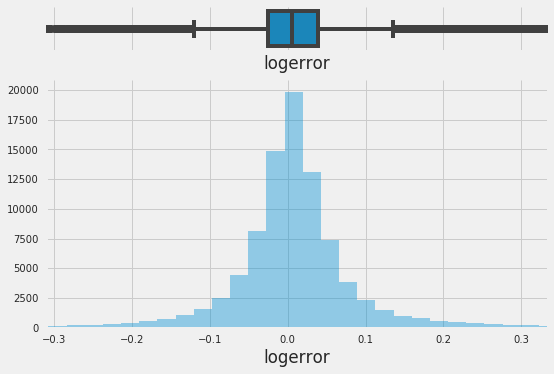

In [11]:
x = df_train['logerror']
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True ,
                                    gridspec_kw={"height_ratios": (.15, .85)})
sns.boxplot(x, ax=ax_box)
sns.distplot(x, ax=ax_hist, bins=400, kde=False)
ax_box.set(yticks=[])
sns.despine(ax=ax_hist)
sns.despine(ax=ax_box, left=True)
plt.xlim([me-2*st, me+2*st])
plt.show()

#### We get that the distribution spikes which very close to zero
- Zillow has Good Data Scientists

# 3. Multivariate Analysis. 
---


## 3.1 Target Variable Distribution Join Fips by Bokeh

- Reference - 
[Philipp Spachtholz](https://www.kaggle.com/philippsp/exploratory-analysis-zillow) FanNotebook, we introduce **Absolute logerror** and **FIPS** codes map to city.


In [12]:
df_train.loc[:,'abs_logerror'] = df_train['logerror'].abs()

- Transaction Date Vs ** Mean Error** in each County

In [21]:
from bokeh.palettes import Spectral4
from bokeh.plotting import figure, output_notebook, show
from bokeh.models import Range1d

fips1 = pd.DataFrame(df_train.loc[df_train['fips']==6037].groupby('transactiondate')['abs_logerror'].mean())
fips1.reset_index(inplace = True)
fips2 = pd.DataFrame(df_train.loc[df_train['fips']==6059].groupby('transactiondate')['abs_logerror'].mean())
fips2.reset_index(inplace = True)
fips3 = pd.DataFrame(df_train.loc[df_train['fips']==6111].groupby('transactiondate')['abs_logerror'].mean())
fips3.reset_index(inplace = True)


output_notebook()
out = figure(plot_width=800, plot_height=250, x_axis_type="datetime")

for data, name, color in zip([fips1, fips2, fips3], ["Los Angeles", "Orange County", "Ventura County"], Spectral4):

    out.line(data['transactiondate'], data['abs_logerror'], line_width=2, color=color, alpha=0.8, legend=name)

out.y_range=Range1d(0, 0.25)    
out.legend.location = "top_left"
#out.legend.click_policy="hide"
show(out)

Loading BokehJS ...

- Year Build Vs **Mean Error** in each County

In [15]:
#yearbuilt
fips1 = pd.DataFrame(df_train.loc[df_train['fips']==6037].groupby('yearbuilt')['abs_logerror'].mean())
fips1.reset_index(inplace = True)
fips2 = pd.DataFrame(df_train.loc[df_train['fips']==6059].groupby('yearbuilt')['abs_logerror'].mean())
fips2.reset_index(inplace = True)
fips3 = pd.DataFrame(df_train.loc[df_train['fips']==6111].groupby('yearbuilt')['abs_logerror'].mean())
fips3.reset_index(inplace = True)

output_notebook()
out = figure(plot_width=800, plot_height=250)

for data, name, color in zip([fips1, fips2, fips3], ["Los Angeles", "Orange County", "Ventura County"], Spectral4):

    out.line(data['yearbuilt'], data['abs_logerror'], line_width=2, color=color, alpha=0.8, legend=name)

out.legend.location = "top_right"
#out.legend.click_policy="hide"
show(out)

Loading BokehJS ...

### An important note:  
- Ventura Country has **Spikes** means Zillow Estimation Inaccurate

In [22]:
import plotly # visualization
from plotly.graph_objs import Scatter, Figure, Layout # visualization
from plotly.offline import download_plotlyjs, init_notebook_mode, plot,iplot # visualization
import plotly.figure_factory as ff # visualization
import plotly.graph_objs as go # visualization
init_notebook_mode(connected=True) # visualization

worst_prediction = df_train['abs_logerror'].quantile(q=.95)


trace0 = go.Scatter(
    y = df_train[(df_train['fips']==6037)&(df_train['abs_logerror']>worst_prediction)].\
                groupby('yearbuilt')['abs_logerror'].mean(),
    x = df_train[(df_train['fips']==6037)&(df_train['abs_logerror']>worst_prediction)].\
                groupby('yearbuilt')['abs_logerror'].mean().index,
    mode = 'lines+markers',
    name = "Los Angeles", 
)
trace1 = go.Scatter(
    y = df_train[(df_train['fips']==6059)&(df_train['abs_logerror']>worst_prediction)].\
                groupby('yearbuilt')['abs_logerror'].mean(),
    x = df_train[(df_train['fips']==6059)&(df_train['abs_logerror']>worst_prediction)].\
                groupby('yearbuilt')['abs_logerror'].mean().index,
    mode = 'lines+markers',
    name = "Orange County"
)
trace2 = go.Scatter(
    y = df_train[(df_train['fips']==6111)&(df_train['abs_logerror']>worst_prediction)].\
                groupby('yearbuilt')['abs_logerror'].mean(),
    x = df_train[(df_train['fips']==6111)&(df_train['abs_logerror']>worst_prediction)].\
                groupby('yearbuilt')['abs_logerror'].mean().index,
    mode = 'lines+markers',
    name = "Ventura County"
)
data = [trace0, trace1, trace2]

plotly.offline.iplot(data, filename='line-mode')



## 3.2 Geographic Location by Folium and Cluster by KMeans

### Introduction:

Folium builds on the data wrangling strengths of the Python ecosystem and the mapping strengths of the Leaflet.js library. 

Manipulate your data in Python, then visualize it in on a Leaflet map via Folium.

In [23]:
geo_df = df_train[['latitude', 'longitude','logerror']]

In [24]:
geo_df['longitude']/=1e6
geo_df['latitude']/=1e6

In [25]:
geo_df.dropna(subset=['latitude','longitude'], axis=0 ,inplace=True)

In [26]:
from sklearn.cluster import MiniBatchKMeans
kmeans = MiniBatchKMeans(n_clusters=120, batch_size=1000).fit(geo_df[['latitude','longitude']])
geo_df.loc[:, 'label'] = kmeans.labels_

In [27]:
map_2 = folium.Map(location=[34.088537, -118.249923],
                   zoom_start=9)
for label in kmeans.cluster_centers_:
    folium.Marker(location=[label][0]).add_to(map_2)

map_2

In [28]:
map_1 = folium.Map(location=[34.088537, -118.249923], zoom_start=9,
                   tiles='Stamen Terrain')
for label in kmeans.cluster_centers_:
    folium.Marker(location=[label][0]).add_to(map_1)
map_1


In [29]:
del map_2 ,map_1
gc.collect()

12

### Finding:
-  Most houses locat in **Flat Ground**
-  Few locat in **Santa Catalina Island**

## 3.3 Where are the Perfect Estimation area ?

- We are going to have a look 
- Ignoring Time Series, i.e Without taking month into consideration 

In [30]:
gc.collect()
perfect_geo_df = geo_df[geo_df['logerror']==0]
perfect_geo_df.shape

(847, 4)

In [31]:
map_perfect = folium.Map(location=[34.088537, -118.249923], zoom_start=9,
                   tiles='Stamen Toner')
for lat, lon in zip(perfect_geo_df.latitude, perfect_geo_df.longitude):
    folium.Marker(location=[lat,lon]).add_to(map_perfect)
map_perfect


In [32]:
del perfect_geo_df, map_perfect, geo_df
gc.collect()

58

### An important note:
- There is no pattern between Geo and perfect Estimation
- Never Happen in the Santa Catalina Island (Millionair hard to predict :-) )

# 4. Time Series Approach
---


## 4.1 Aggragation & Visualisation


### OverAll Average Absolute Log Error

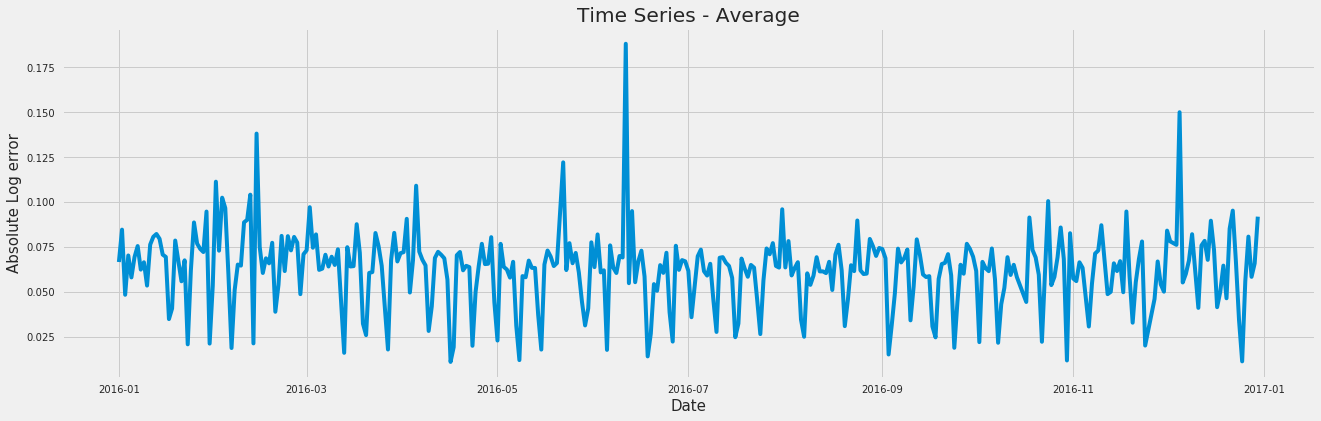

In [33]:
plt.figure(figsize=(20, 6))
mean_group = df_train[['transactiondate','abs_logerror']].groupby(['transactiondate'])['abs_logerror'].mean()
plt.plot(mean_group)
plt.xlabel('Date', fontsize=15)
plt.ylabel('Absolute Log error', fontsize=15)
plt.title('Time Series - Average')
plt.show()

### Los Angeles Average Absolute Log error

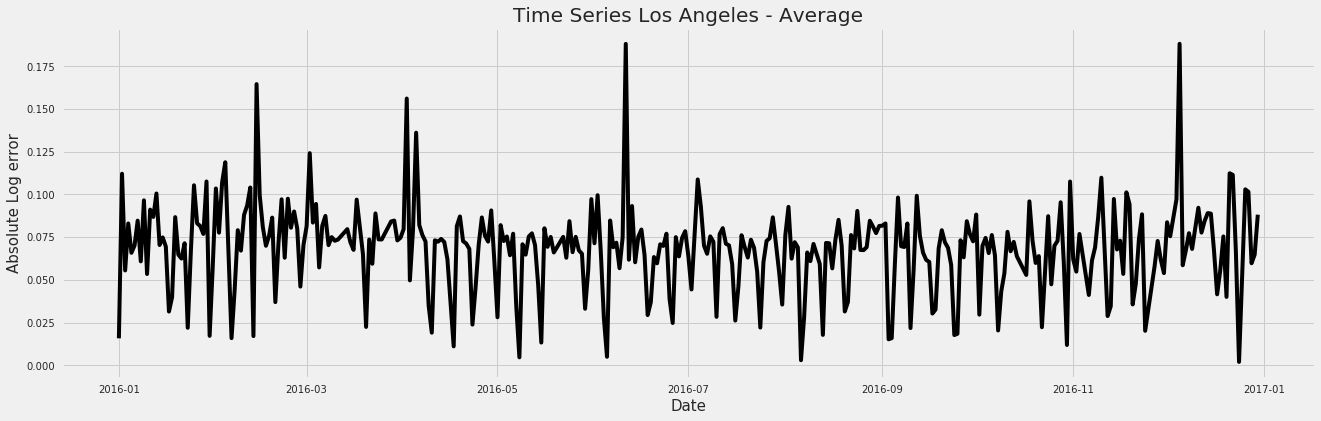

In [34]:
plt.figure(figsize=(20, 6)) 
fips1 = pd.DataFrame(df_train.loc[df_train['fips']==6037].groupby('transactiondate')['abs_logerror'].mean())
plt.plot(fips1,c='k')
plt.xlabel('Date', fontsize=15)
plt.ylabel('Absolute Log error', fontsize=15)
plt.title('Time Series Los Angeles - Average')
plt.show()

### Orange County Average Absolute Log error

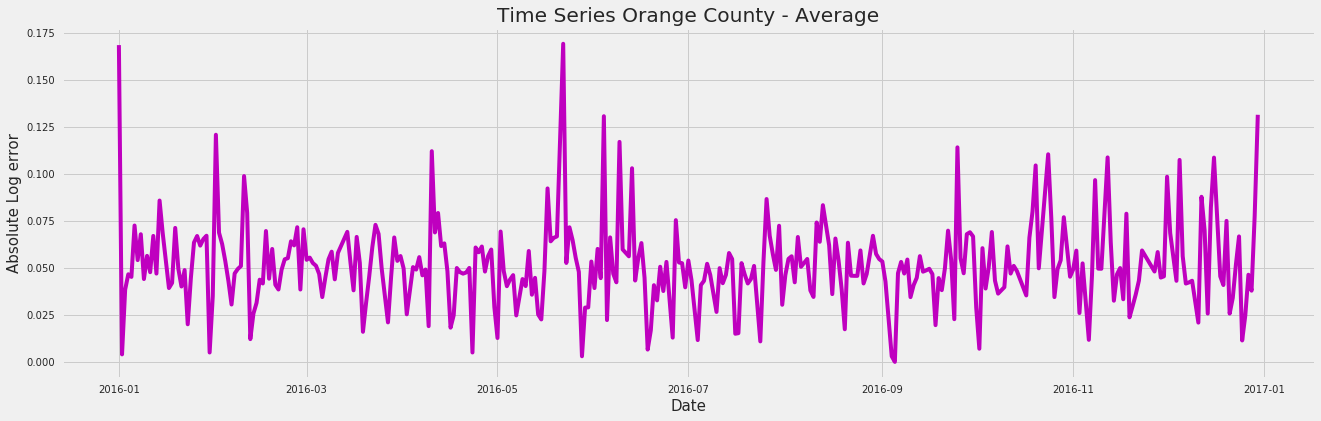

In [35]:
plt.figure(figsize=(20, 6)) 
fips1 = pd.DataFrame(df_train.loc[df_train['fips']==6059].groupby('transactiondate')['abs_logerror'].mean())
plt.plot(fips1, c = 'm')
plt.xlabel('Date', fontsize=15)
plt.ylabel('Absolute Log error', fontsize=15)
plt.title('Time Series Orange County - Average')
plt.show()

### Ventura County  Average Absolute Log error

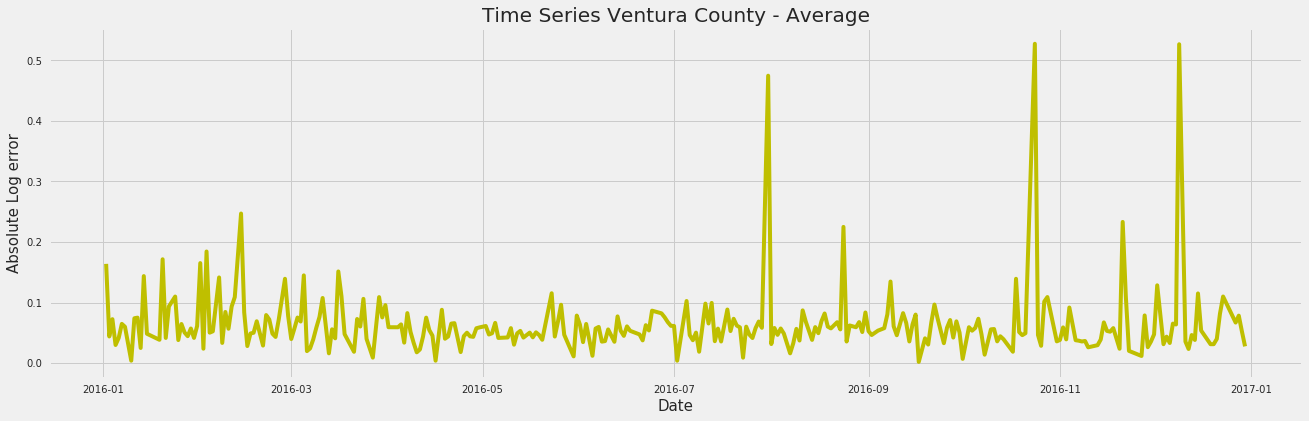

In [36]:
plt.figure(figsize=(20, 6))
fips1 = pd.DataFrame(df_train.loc[df_train['fips']==6111].groupby('transactiondate')['abs_logerror'].mean())
plt.plot(fips1, c = 'y')
plt.xlabel('Date', fontsize=15)
plt.ylabel('Absolute Log error', fontsize=15)
plt.title('Time Series Ventura County - Average')
plt.show()

- Median of Absolute Logerror

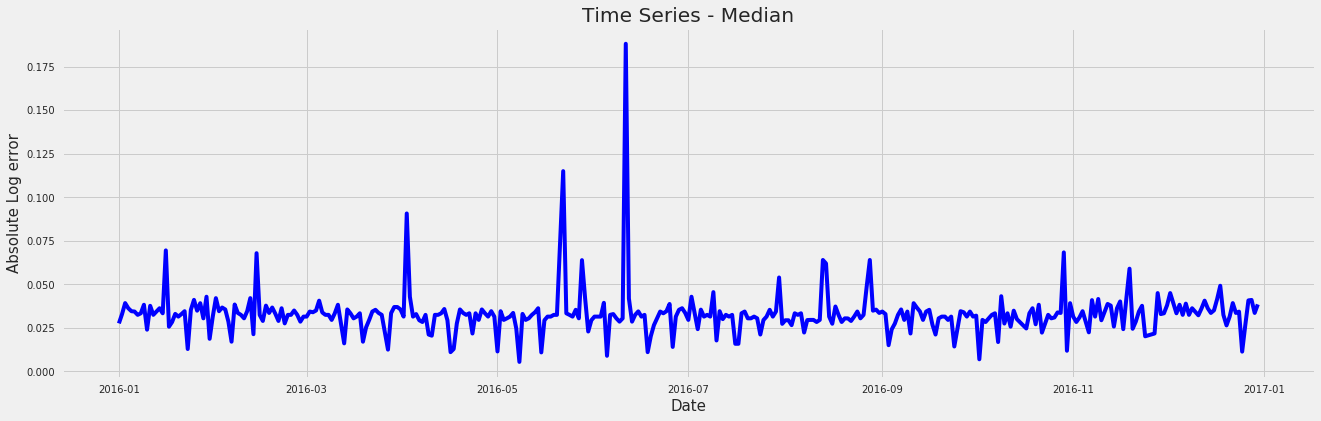

In [37]:
plt.figure(figsize=(20, 6))
median_group = df_train[['transactiondate','abs_logerror']].groupby(['transactiondate'])['abs_logerror'].median()
plt.plot(median_group, c='b')
plt.xlabel('Date', fontsize=15)
plt.ylabel('Absolute Log error', fontsize=15)
plt.title('Time Series - Median')
plt.show()

- Standard Deviation of Absolute Logerror

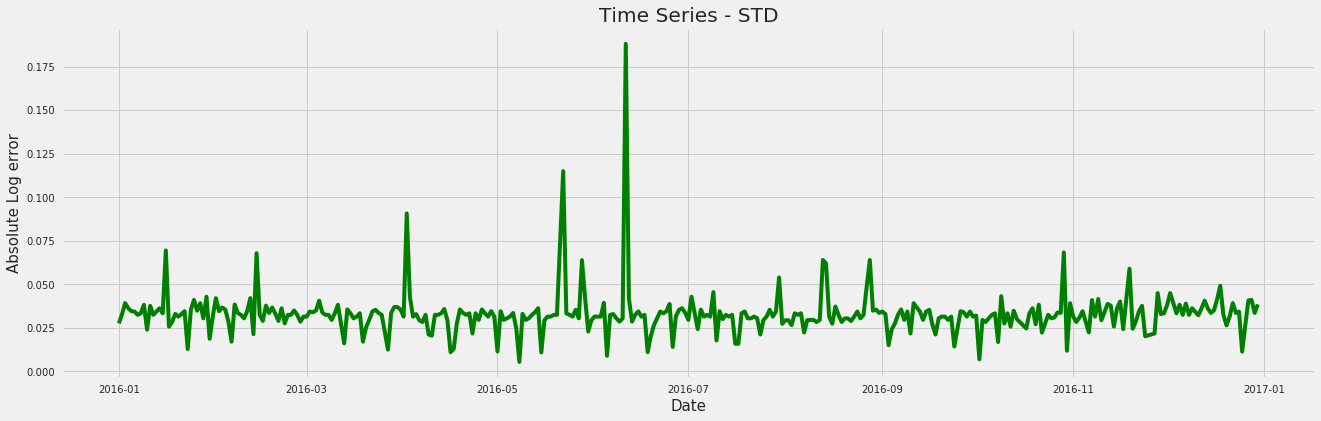

In [38]:
plt.figure(figsize=(20, 6))
std_group = df_train[['transactiondate','abs_logerror']].groupby(['transactiondate'])['abs_logerror'].median()
plt.plot(std_group, c='g')
plt.xlabel('Date', fontsize=15)
plt.ylabel('Absolute Log error', fontsize=15)
plt.title('Time Series - STD')
plt.show()

In [32]:
del mean_group, median_group, std_group
gc.collect()

30207


Here, I only use inliner 
    - Definition:  Absolute Logerror < Mean + Std

In [33]:
df_train = df_train[df_train['abs_logerror']<  me + st ]
mean_group = df_train[['transactiondate','abs_logerror']].groupby(['transactiondate'])['abs_logerror'].mean()

### Time Series Components
  
- A given time series is thought to consist of three systematic components including level, trend, seasonality, and one non-systematic component called noise. These components are defined as follows:

    1. **Level**: The average value in the series.
    2. **Trend**: The increasing or decreasing value in the series. 
    3. **Seasonality**: The repeating short-term cycle in the series. 
    4. **Noise**: The random variation in the series.



In [44]:
df_date_index.dtypes

abs_logerror    float32
dtype: object

### Combining Time Series Components
- A series is thought to be an aggregate or combination of these four components. All series have a level and noise. The trend and seasonality components are optional. It is helpful to think of the components as combining either **additively** or **multiplicatively**.

    - Additive Model
        y(t) = Level + Trend + Seasonality + Noise 
        
    - Multiplicative Model
        y(t) = Level x Trend x Seasonality x Noise 


- Additive Model

In [45]:
df_date_index.index=pd.to_datetime(df_date_index.index)

In [51]:
times_series_means =  pd.DataFrame(mean_group).reset_index(drop=False)
df_date_index = times_series_means[['transactiondate','abs_logerror']].set_index('transactiondate')
decomposition = sm.tsa.seasonal_decompose(df_date_index.abs_logerror, model='additive',freq = 31)
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid
rcParams['figure.figsize'] = 15, 8

plt.subplot(411)
plt.title('Obesered = Level + Trend + Seasonality + Noise ')
plt.plot(df_date_index, label='Observed')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

TypeError: 'numpy.float64' object cannot be interpreted as an index

- Multiplicative

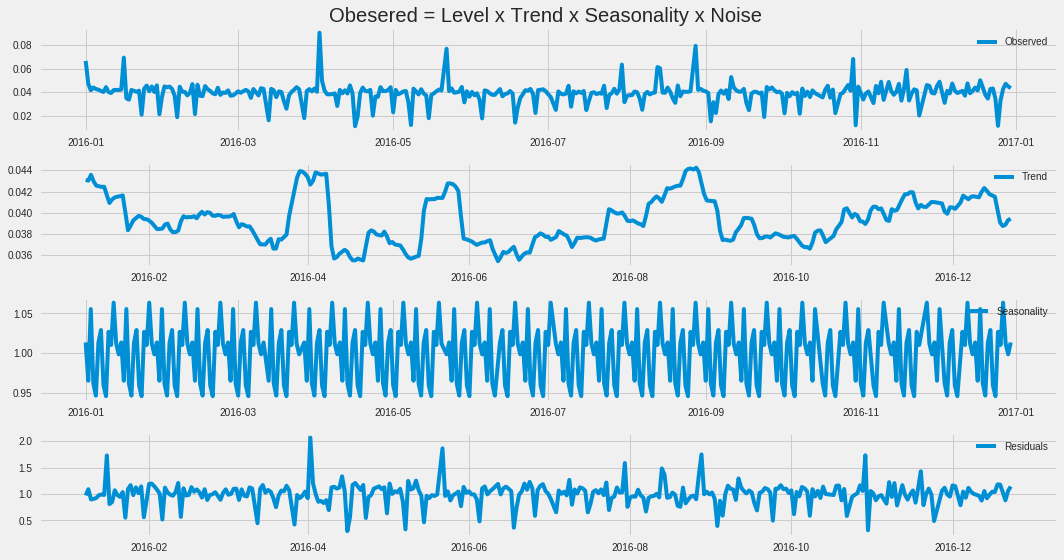

In [35]:
times_series_means =  pd.DataFrame(mean_group).reset_index(drop=False)
df_date_index = times_series_means[['transactiondate','abs_logerror']].set_index('transactiondate')
decomposition = sm.tsa.seasonal_decompose(df_date_index, model='multiplicative',freq = 14)
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid
rcParams['figure.figsize'] = 15, 8

plt.subplot(411)
plt.title('Obesered = Level x Trend x Seasonality x Noise ')
plt.plot(df_date_index, label='Observed')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

## 4.2 Moving Average Smoothing / Random Walk and Stationarity

Moving average smoothing is a naive and effective technique in time series forecasting. It can be used for data preparation, feature engineering, and even directly for making predictions.

A stationary time series is one where the values are not a function of time. We can confirm this using a statistical significance test, specifically the Augmented Dickey-Fuller test.

- The script is copied from kaggler 
    1. [Julien Heiduk](https://www.kaggle.com/zoupet) and  
    2. https://www.analyticsvidhya.com/blog/2016/02/time-series-forecasting-codes-python/ 
    3. [Dr. Jason Brownlee]()

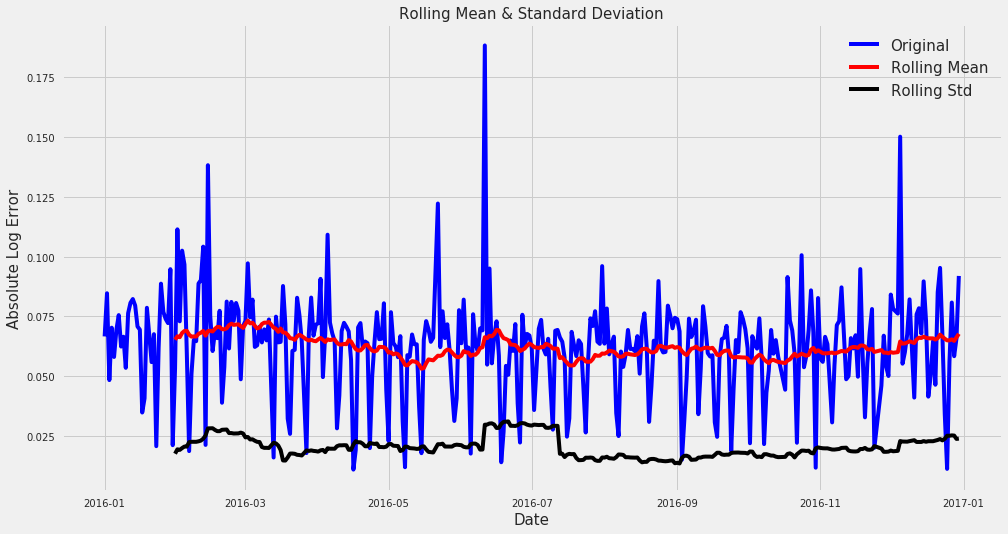

Results of Dickey-Fuller Test:
Test Statistic                  -4.892494
p-value                          0.000036
#Lags Used                      12.000000
Number of Observations Used    339.000000
Critical Value (5%)             -2.870104
Critical Value (1%)             -3.449788
Critical Value (10%)            -2.571332
dtype: float64


In [52]:
def test_stationarity(timeseries):
    plt.figure(figsize=(15, 8))
    #Determing rolling statistics
    rolmean = pd.rolling_mean(timeseries, window=31) # Slide window depend on past 1 month
    rolstd = pd.rolling_std(timeseries, window=31)

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best', fontsize=15)
    plt.title('Rolling Mean & Standard Deviation', fontsize=15)
    plt.xlabel('Date', fontsize=15)
    plt.ylabel('Absolute Log Error', fontsize=15)
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = sm.tsa.adfuller(timeseries['abs_logerror'], autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    
test_stationarity(df_date_index)   

The **null hypothesis** of the test is that the time series is **non-stationary** and we can see that the test statistic value was **-1.736474e+01** with a significance level of less than **1%** (i.e. a low probability that the result is a statistical fluke). 

Rejecting the null hypothesis means that the process has no unit root, and in turn that the time series is ** stationary** or does not have time-dependent structure.

# Non Time Dependent Structure
- Under Constraint
    - Exclude Outlier
    - Only depend on past 3 months 

## 4.3 Prophet Forecasting
### This is inspired by kaggler [Julien Heiduk](https://www.kaggle.com/zoupet)

- This tool was created by Facebook. 
More information on the library here: https://research.fb.com/prophet-forecasting-at-scale/


Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


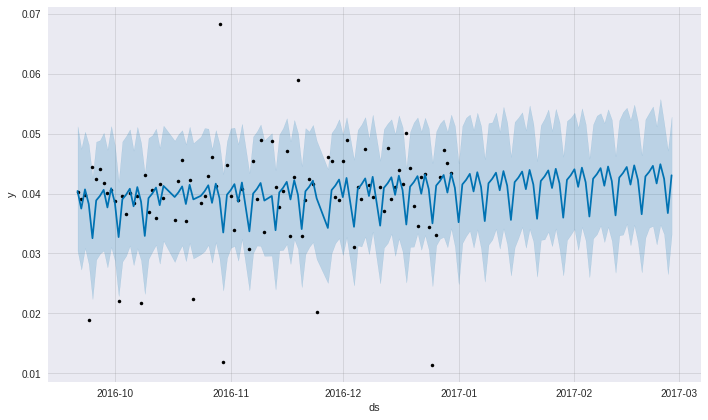

In [37]:
sns.set(font_scale=1) 
df_prophet =  pd.DataFrame(mean_group).reset_index(drop=False)
df_prophet = df_prophet.iloc[-92:,:] # Forecast due to past 3 months
df_prophet.columns = ['ds','y']

m = Prophet()
m.fit(df_prophet)
future = m.make_future_dataframe(periods=59,freq='D') # Forecast Jan 2017
forecast = m.predict(future)
plt.figure(figsize=(30, 6))
fig = m.plot(forecast)
plt.show()

## Reference
- [1] [Philipp Spachtholz](https://www.kaggle.com/philippsp/exploratory-analysis-zillow)
- [2] [Julien Heiduk](https://www.kaggle.com/zoupet) 
- [3] [Aarshay Jain](https://www.analyticsvidhya.com/blog/author/aarshay/) A comprehensive beginner’s guide to create a Time Series Forecast
- [4] [Dr. Jason Brownlee]()



## Stay tuned, this notebook will be updated on a regular basis
